In [1]:
library(matrixStats)
library("randomForest")
library(e1071)
library(plotROC)
library(glmnet)

#install.packages("tidyverse")
library(tidyverse)
library(modelr)
# Data Handling

if (!requireNamespace("BiocManager"))
    install.packages("BiocManager")
BiocManager::install()
library(BiocManager)
# General bioinformatics packages

library(BSgenome)
library(BSgenome.Hsapiens.UCSC.hg19)
# Human genome build GChr37

library(biomaRt)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Warning message:
“package ‘e1071’ was built under R version 3.5.2”Loading required package: ggplot2

Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

    margin

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.0.1     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ dplyr   0.7.8
✔ readr   1.1.1     ✔ stringr 1.3.1
✔ tibble  2.0.1     ✔ forcats 0.3.0
Warning message:
“package ‘tibble’ was built under R version 3.5.2”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ dplyr::combine()    masks randomForest::combine()
✖ dplyr::count()      masks matrixStats::count()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()       

In [2]:
source("TMB_Funcs.txt")
# My Stuff!

path_name <- "/Volumes/CCG8/processed_data"
genome <- BSgenome.Hsapiens.UCSC.hg19
ensembl = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
select <- dplyr::select

### Load Data

In [3]:
three_cancer_data <- read_rds("/Users/jacobbradley/Documents/CCG/Data/three_cancer_data")
lung_data <- read_rds("/Users/jacobbradley/Documents/CCG/Data/lung_data")

In [4]:
all_lung_stats <- read_rds("/Users/jacobbradley/Documents/CCG/Data/all_lung_stats")

In [77]:
### Functions for using LASSO from a gene, length-weighted perspective

get_lasso_models <- function(training_data, gene_lengths, report = FALSE) {
    
    if (report) {message("finding usable genes")}
    training_genes <- unique(training_data$Hugo_Symbol)
    genes_with_lengths <- gene_lengths %>% 
        filter(!is.na(length)) %>% 
        pull(Hugo_Symbol)
    
    usable_genes <- intersect(training_genes, genes_with_lengths)
    
    training_data <- training_data %>%    
        filter(Hugo_Symbol %in% usable_genes)
    
    if (report) {message("constructing training matrix")}
    
    training_matrix <- get_gene_matrix(training_data, usable_genes) %>% 
        ungroup()
    
    x <- as.matrix(training_matrix %>% 
                        select(-c(Tumor_Sample_Barcode, TMB)))
    y <- training_matrix$TMB
    
    ordered_lengths <- gene_lengths %>% 
        filter(Hugo_Symbol %in% usable_genes) %>% 
        arrange(Hugo_Symbol) %>% 
        pull(length)
    
    if (report) {message("computing models")}
    
    
    models <- glmnet(x, y, family = "gaussian", penalty.factor = ordered_lengths)
    
    return(models)
}



In [78]:
first_lasso_run <- get_lasso_models(lung_data[["training_data"]], all_lung_stats, report = TRUE)

finding usable genes
constructing training matrix
computing models


In [79]:
first_lasso_run$lambda

[1] 21.6549383 20.6706880 19.7311733 18.8343610 17.9783103 17.1611683
  [7] 16.3811667 15.6366174 14.9259090 14.2475034 13.5999324 12.9817945
 [13] 12.3917519 11.8285276 11.2909028 10.7777138 10.2878501  9.8202515
 [19]  9.3739059  8.9478474  8.5411539  8.1529453  7.7823813  7.4286601
 [25]  7.0910160  6.7687184  6.4610697  6.1674041  5.8870861  5.6195089
 [31]  5.3640936  5.1202873  4.8875623  4.6654150  4.4533647  4.2509524
 [37]  4.0577401  3.8733095  3.6972616  3.5292154  3.3688071  3.2156896
 [43]  3.0695316  2.9300166  2.7968428  2.6697220  2.5483790  2.4325513
 [49]  2.3219881  2.2164501  2.1157090  2.0195468  1.9277553  1.8401358
 [55]  1.7564988  1.6766632  1.6004563  1.5277131  1.4582762  1.3919953
 [61]  1.3287269  1.2683343  1.2106865  1.1556589  1.1031324  1.0529934
 [67]  1.0051332  0.9594483  0.9158399  0.8742136  0.8344792  0.7965509
 [73]  0.7603464  0.7257875  0.6927993  0.6613105  0.6312529  0.6025615
 [79]  0.5751742  0.5490316  0.5240773  0.5002572  0.4775197  0.4558157
 [85]  0.4350982  0.4153223  0.3964452  0.3784262  0.3612261  0.3448079
 [91]  0.3291358  0.3141761  0.2998963  0.2862655  0.2732543  0.2608345
 [97]  0.2489792  0.2376627  0.2268605  0.2165494

In [47]:
names(first_lasso_run)

[1] "a0"        "beta"      "df"        "dim"       "lambda"    "dev.ratio"
 [7] "nulldev"   "npasses"   "jerr"      "offset"    "call"      "nobs"

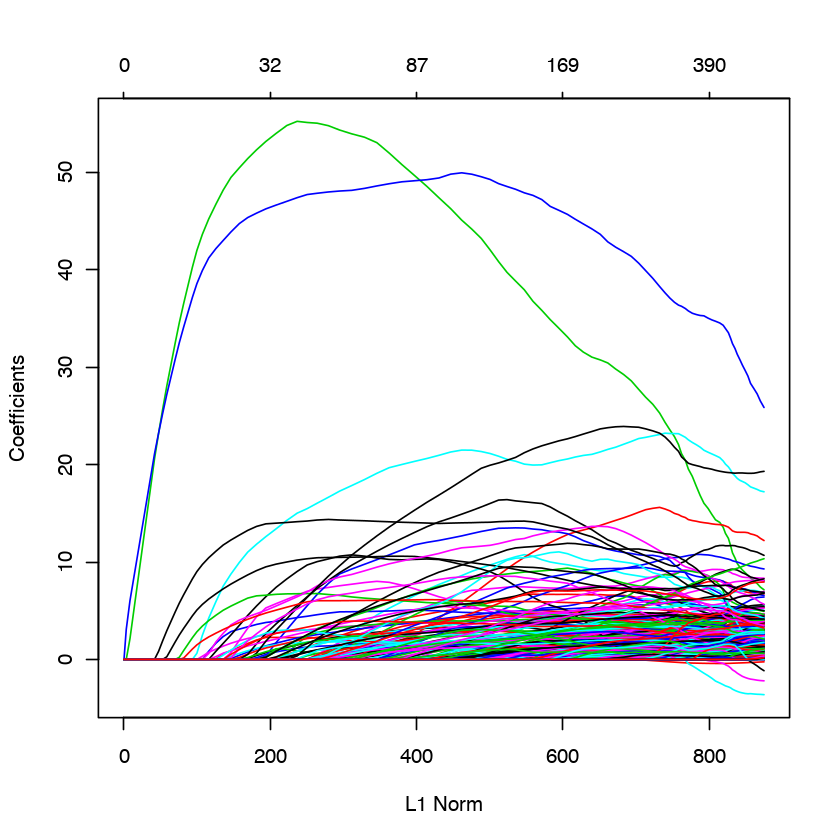

In [96]:
plot(first_lasso_run)

In [158]:
first_lasso_run_panel_sizes <- lasso_panel_sizes(first_lasso_run, lung_data, type = "AUC", report = TRUE)

making panels
making matrices
making and testing models
hi
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


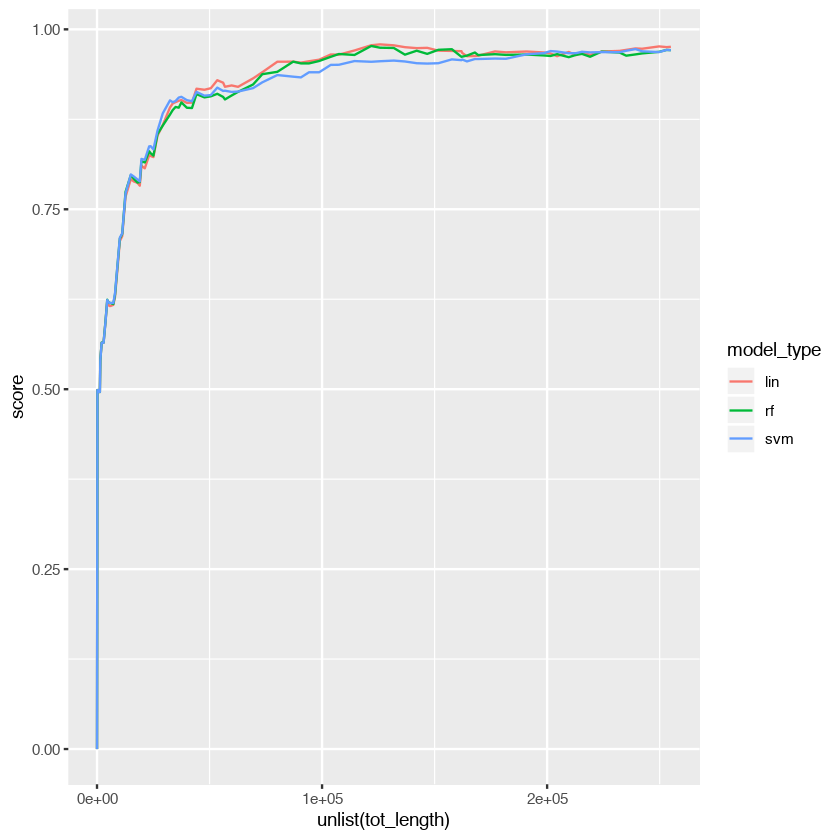

In [162]:
first_lasso_run_panel_sizes[["panel_data"]] %>% 
    ggplot(aes(x = unlist(tot_length), y = score, colour = model_type)) + geom_line()

In [157]:
lasso_panel_sizes <- function(lasso_run, data, type, report = FALSE) {
    
    iters <- ncol(first_lasso_run$beta)
    panels <- list(rep(NA, iters))

    if (report) {message("making panels")}
    for (i in 1:iters) {
        panels[[i]] <- rownames(first_lasso_run$beta)[which(first_lasso_run$beta[,i] > 0)]
    }
        
    if (report) {message("making matrices")}
    big_matrix <- get_gene_matrix(data[["training_data"]], unique(unlist(panels))) %>% 
       ungroup()
    big_test_matrix <- get_gene_matrix(data[["test_data"]], unique(unlist(panels))) %>% 
        ungroup() 
    for (missing_gene in setdiff(colnames(big_matrix), colnames(big_test_matrix))) {
        big_test_matrix[[missing_gene]] <- 0
    }

    
    if (report) {message("making and testing models")}
    panel_test <- rep(NA, length(panels))
   
    for (i in 1:length(panels)) {
        message(i)
        
        pan <- panels[[i]]
        
        matrix <- big_matrix %>% 
            select(TMB, Tumor_Sample_Barcode, !!!pan)
        if (length(pan) > 0) {
            model <- get_gene_model(model_genes = pan, data = data[["training_data"]], matrix = matrix)
            rf_model <- get_gene_f_model(model_genes = pan, data = data[["training_data"]], matrix = matrix)
            svm_model <- get_gene_svm_model(model_genes = pan, data = data[["training_data"]], matrix = matrix)

            test_matrix <- big_test_matrix %>% 
                  select(TMB, !!!pan)
            panel_test[i] <- testModel(model, test_matrix, type = type)
            panel_test[i + length(panels)] <- testModel(rf_model, test_matrix, type = type)
            panel_test[i + 2*length(panels)] <- testModel(svm_model, test_matrix, type = type)
        }
        else {
            panel_test[i] <- 0
            panel_test[i + length(panels)]  <- 0
            panel_test[i + 2*length(panels)] <- 0
        }

    }

    panels_data <- tibble(n_genes = rep(map(panels, length), 3),
                          tot_length = rep(map(panels, ~ sum(filter(all_lung_stats, Hugo_Symbol %in% .x)$length)),3),
                          score = panel_test, test_type = type)
    
    output <- list(panels, panels_data)
    names(output) <- c("panels", "panel_data")

    return(output)
}

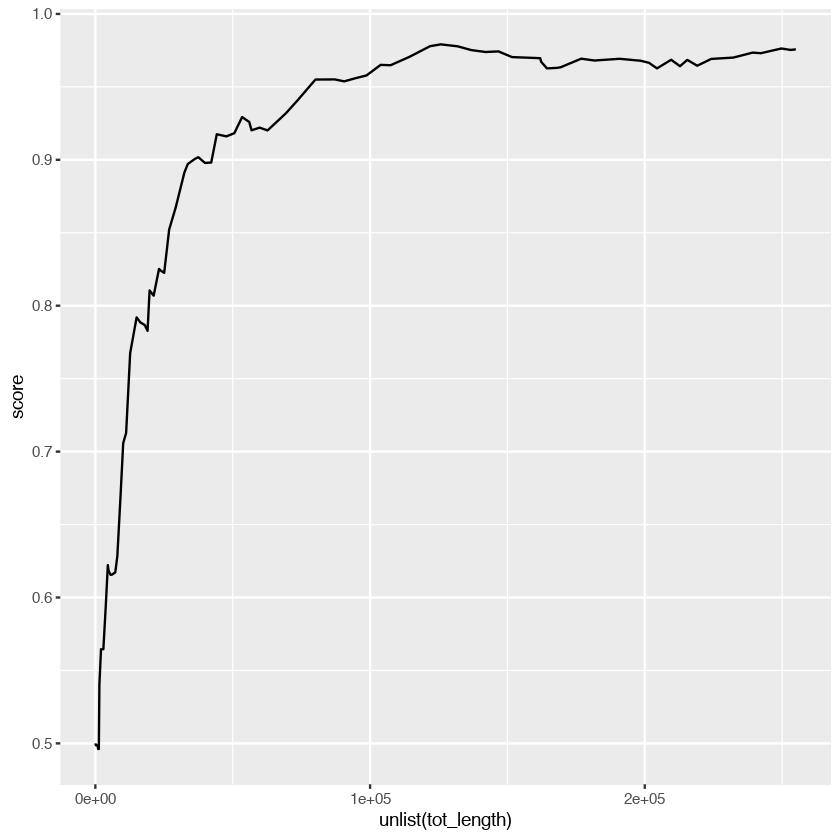

In [132]:
first_lasso_run_panel_sizes[["panel_data"]] %>% 
   ggplot(aes(x = unlist(tot_length), y = score)) + geom_line()

In [152]:
length(panels[[1]])

[1] 0